In [1]:
!pip install --quiet -U gensim

     |████████████████████████████████| 24.1 MB 1.4 MB/s 


In [2]:
!pip install --quiet transformers

     |████████████████████████████████| 4.7 MB 5.1 MB/s 
     |████████████████████████████████| 6.6 MB 35.3 MB/s 
     |████████████████████████████████| 120 kB 52.7 MB/s 


In [3]:
!pip3 install --quiet keras

In [4]:
!pip3 install --quiet keras

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd drive/MyDrive/AML/HW4/classifier

/content/drive/MyDrive/AML/HW4/classifier


In [7]:
!ls

 BERT-classification-on-text-augmented.ipynb
 BERT-classification-on-text.ipynb
 BERT-pretrained-features.ipynb
 classification_test_results.tsv
 dreaddit
 dreaddit-test.csv
 dreaddit-train.csv
 dreddit.ipynb
 GoogleNews-vectors-negative300.bin
 GoogleNews-vectors-negative300.bin.gz
 logs
 pre-trained-BERT-features-2.ipynb
 results
 tBERT_LDA_augmented_dreddit.ipynb
 tBERT_with_LDA_for_dreddit.ipynb
 test_data.tsv
 tfi-df-embeddings.ipynb
 train_data_for_students.tsv
 trump_tweets_classifiers.ipynb
'w2v_domain_trained_ GSDMM.ipynb'
 w2v-domain-trained.ipynb
 w2v_domain_trained_lda_augmented_self_training.ipynb
 w2v-domain-trained-lda.ipynb
 w2v_domain_trained_LDA_multilabled.ipynb
 w2v-google-news-pretrained.ipynb


In [8]:
# Data processing
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer

import transformers
import torch
from transformers import AutoModel, AutoTokenizer
from transformers import Trainer, TrainingArguments
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available

# Visualization
from matplotlib import pyplot as plt

import nltk
from nltk.corpus import stopwords

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import LabelEncoder

# Text processing
import re
import nltk
import gensim.downloader as api

# Various
from datetime import datetime
#Google Drive
from google.colab import drive

import re
import tqdm

import gensim, logging


In [9]:
def set_seed(seed: int):
    # numpy
    np.random.seed(seed)

    # torch
    if is_torch_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
         
set_seed(42)

In [10]:
def concat_two(original, new_x, features_from_original):
  new_df = pd.concat([new_x, original[features_from_original]], axis=1)
  return new_df

In [11]:
def get_domain(subreddit):
  if subreddit=='domesticviolence' or subreddit=='survivorsofabuse':
    return 'abuse';
  if subreddit=='anxiety' or subreddit=='stress':
    return 'anxiety';
  if subreddit=='almosthomeless' or subreddit=='assistance' or subreddit=='food_pantry' or subreddit=='homeless':
    return 'financial';
  if subreddit=='ptsd':
    return 'ptsd';
  else:
    return 'social';

In [12]:
df=pd.read_csv('dreaddit/dreaddit-train.csv')
df.shape

(2838, 116)

In [13]:
df_test = pd.read_csv('dreaddit/dreaddit-test.csv')
df_test.shape

(715, 116)

In [14]:
df['text_clean'] = df['text'].apply(lambda x: gensim.utils.simple_preprocess(x))
df['domain'] = df['subreddit'].map(lambda x: get_domain(x))
X_train = df['text_clean']
y_train = df['label']
y_train = y_train.to_list()
df.head(2)

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment,text_clean,domain
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.8,1521614353,5,1.806818,...,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742,"[he, said, he, had, not, felt, that, way, befo...",ptsd
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.0,1527009817,4,9.429737,...,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857,"[hey, there, assistance, not, sure, if, this, ...",financial


In [15]:
df_test['text_clean'] = df_test['text'].apply(lambda x: gensim.utils.simple_preprocess(x))
df_test['domain'] = df_test['subreddit'].map(lambda x: get_domain(x))
X_test = df_test['text_clean']
y_test = df_test['label']
y_test = y_test.to_list()
df_test.head(2)

,id,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment,text_clean,domain
0,896,relationships,7nu7as,"[50, 55]","Its like that, if you want or not.“ ME: I have...",0,0.8,1.514981e+09,22,-1.238793,...,1.0,1.65864,1.32245,1.80264,0.63,62,-0.148707,0.000000,"[its, like, that, if, you, want, or, not, me, ...",social
1,19059,anxiety,680i6d,"(5, 10)",I man the front desk and my title is HR Custom...,0,1.0,1.493348e+09,5,7.684583,...,1.0,1.69133,1.69180,1.97249,1.00,2,7.398222,-0.065909,"[man, the, front, desk, and, my, title, is, hr...",anxiety


In [16]:
ll = df[df.columns[1:]].corr().abs()['label'].sort_values(ascending = False)[:16].gt(0.2).drop('label')

In [17]:
top_correlations = list(ll.index)
top_correlations

['lex_liwc_Tone',
 'lex_liwc_Clout',
 'lex_liwc_i',
 'lex_liwc_negemo',
 'sentiment',
 'lex_dal_min_pleasantness',
 'lex_liwc_Authentic',
 'lex_liwc_posemo',
 'lex_liwc_anx',
 'lex_liwc_social',
 'lex_liwc_Analytic',
 'lex_liwc_Dic',
 'lex_liwc_function',
 'lex_liwc_anger',
 'lex_liwc_you']

In [18]:
expected_vector_size=300

In [19]:
w2v_model = gensim.models.Word2Vec(X_train,
                                   vector_size=expected_vector_size,
                                   window=5,
                                   min_count=2)

In [20]:
len(set(w2v_model.wv.index_to_key ))

6167

In [21]:
w2v_model.wv.most_similar('stress')

[('case', 0.9995608925819397),
 ('im', 0.9992623925209045),
 ('serious', 0.9992495775222778),
 ('medication', 0.9992032051086426),
 ('huge', 0.9991990327835083),
 ('its', 0.9991673827171326),
 ('loud', 0.9990829229354858),
 ('beyond', 0.9990783333778381),
 ('feelings', 0.9990318417549133),
 ('big', 0.999009370803833)]

In [22]:
words = set(w2v_model.wv.index_to_key )

X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_train])
X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_test])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [23]:
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        # print('no v.size')
        X_train_vect_avg.append(np.zeros(expected_vector_size, dtype=float))
        
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        # print('no v.size in test')
        X_test_vect_avg.append(np.zeros(expected_vector_size, dtype=float))

In [24]:
np.array(X_train_vect_avg).shape

(2838, 300)

In [25]:
ff = top_correlations
len(ff)

15

In [26]:
df.shape

(2838, 118)

In [27]:
X = pd.DataFrame(X_train_vect_avg)
print(f'X.shape = {X.shape}')
test_X = pd.DataFrame(X_test_vect_avg)
print(f'test_X.shape = {test_X.shape}')

X = concat_two(df, X, ff)
print(f'features - X.shape = {X.shape}')
test_X = concat_two(df_test, test_X, ff)
print(f'features - test_X.shape = {test_X.shape}')

# le_train = LabelEncoder()
# X = X.assign(subreddit = le_train.fit_transform(df['subreddit']))
# print(f'features + subreddit - X.shape = {X.shape}')

# le_test = LabelEncoder()
# test_X = test_X.assign(subreddit = le_test.fit_transform(df_test['subreddit']))
# print(f'features + subreddit - test_X.shape = {test_X.shape}')

X.shape = (2838, 300)
test_X.shape = (715, 300)
features - X.shape = (2838, 315)
features - test_X.shape = (715, 315)


In [28]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

In [29]:
def get_models():
    
    models = dict()
    models['lr'] = make_pipeline(StandardScaler(),LogisticRegression(solver = 'saga', C = 70.0))
    models['svm'] = make_pipeline(StandardScaler(),SVC())
    models['xgboost'] = XGBClassifier(n_estimators = 11, max_depth = 1)
    models['GBM'] = GradientBoostingClassifier(n_estimators = 10)
    models['adaboost'] = AdaBoostClassifier(n_estimators= 12)
    
    return models

In [30]:
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=4, random_state=1)
	scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
	return scores

>lr 0.78 (0.03)
>svm 0.77 (0.03)
>xgboost 0.74 (0.02)
>GBM 0.76 (0.02)
>adaboost 0.75 (0.03)


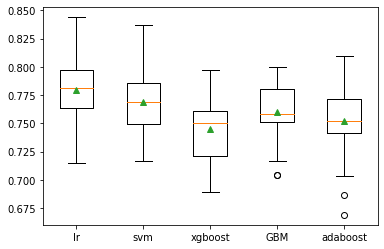

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import mean
from numpy import std

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y_train)
	results.append(scores)
	names.append(name)
	print('>%s %.2f (%.2f)' % (name, scores.mean(), std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [32]:
from sklearn.model_selection import GridSearchCV


classifier_lr = LogisticRegression()
model_lr = Pipeline([("classifier", classifier_lr)])


param_grid = [
    {'classifier__C': [1e-5, 1e-3, 1e-1, 1e0, 1e1, 70.0, 1e2, 1e5]},
    {'classifier__penalty' : ['l2']},
    {'classifier__solver'  : ['newton-cg', 'saga', 'lbfgs', 'liblinear']}
]

# Create grid search object

clf = GridSearchCV(model_lr, param_grid = param_grid, cv = 10, verbose=True, n_jobs=-1)

# Fit on data

model_lr = clf.fit(X.to_numpy(), y_train)

Fitting 10 folds for each of 13 candidates, totalling 130 fits


In [33]:
print(model_lr)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'classifier__C': [1e-05, 0.001, 0.1, 1.0, 10.0, 70.0,
                                            100.0, 100000.0]},
                         {'classifier__penalty': ['l2']},
                         {'classifier__solver': ['newton-cg', 'saga', 'lbfgs',
                                                 'liblinear']}],
             verbose=True)


In [34]:
predicted_train_lr = model_lr.predict(X.to_numpy())
accuracy_train_lr = accuracy_score(y_train, predicted_train_lr)
print('Accuracy Training data: {:.1%}'.format(accuracy_train_lr))

predicted_test_lr = model_lr.predict(test_X.to_numpy())
accuracy_test_lr = accuracy_score(y_test, predicted_test_lr)
print('Accuracy Test data: {:.1%}'.format(accuracy_test_lr))

Accuracy Training data: 75.2%
Accuracy Test data: 75.0%


In [35]:
print(classification_report(y_test, predicted_test_lr))

              precision    recall  f1-score   support

           0       0.77      0.68      0.73       346
           1       0.73      0.81      0.77       369

    accuracy                           0.75       715
   macro avg       0.75      0.75      0.75       715
weighted avg       0.75      0.75      0.75       715



In [36]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predicted_test_lr)

array([[237, 109],
       [ 70, 299]])